<a href="https://colab.research.google.com/github/imenebak/MLOps-coursera-DeepLearning.ai/blob/main/C1W3_Data_Labeling_Ungraded_Lab/C1W3_Data_Labeling_Ungraded_Lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
!unzip "/content/Files.zip"

Archive:  /content/Files.zip
  inflating: Files/Youtube01-Psy.csv  
  inflating: Files/Youtube02-KatyPerry.csv  
  inflating: Files/Youtube03-LMFAO.csv  
  inflating: Files/Youtube04-Eminem.csv  
  inflating: Files/Youtube05-Shakira.csv  


**Loading the dataset**
The dataset consists of 5 CSV files, one for each video. Pandas DataFrame are very powerful to handle data in CSV format. The following helper function will load the data using pandas:

In [ ]:
def load_labeled_spam_dataset():
    """Load labeled spam dataset."""

    # Path where csv files are located
    base_path = "/content/Files/"

    # List of csv files with full path
    csv_files = [os.path.join(base_path, csv) for csv in glob.glob(base_path+"*.csv")]

    # List of dataframes for each file
    dfs = [pd.read_csv(filename) for filename in csv_files]

    # Concatenate dataframes into a single one
    df = pd.concat(dfs)

    # Rename columns
    df = df.rename(columns={"CONTENT": "text", "CLASS": "label"})

    # Set a seed for the order of rows
    df = df.sample(frac=1, random_state=824)
    
    return df.reset_index()


# Save the dataframe into the df_labeled variable
df_labeled = load_labeled_spam_dataset()

In [ ]:
# Take a look at the first 5 rows
df_labeled.head()

,index,COMMENT_ID,AUTHOR,DATE,text,label
0,106,z12njp45xonlypf2x23ketjjpzjee3cyt04,bea boots,2014-09-14T12:42:56,great song you go katy!﻿,0
1,311,_2viQ_Qnc68ked0J7OAfephXPfR-pvW7HiuIC5ZRduI,macgyver16,2013-08-16T14:07:09.668000,adf.ly /KlD3Y,1
2,250,z12hif0a3nj0vlkxj04cif1wcpuxvf0gpno0k,Hazetrix (EHazardStudio),2015-04-08T00:09:33.033000,hey guys im 17 years old remixer and producer ...,1
3,255,z132t3fhixrdghdhu04ciz2i4ovhezcgnrc0k,Law Halkett,2015-03-29T07:12:48.792000,Check out this video on YouTube: <br />﻿,1
4,346,_2viQ_Qnc68cxHfQzecR1L9f-hbLNIJ7VxpCZtctPMk,yakikukamo FIRELOVER,2013-07-18T17:07:06.152000,hey you ! check out the channel of Alvar Lake !!,1


*Further inspection and preprocessing*

**Checking for data imbalance**

It is fairly common to assume that the data you are working on is balanced. This means that the dataset contains a similar proportion of examples for all classes. Before moving forward let's actually test this assumption:

Value counts for each class:

1    1005
0     951
Name: label, dtype: int64



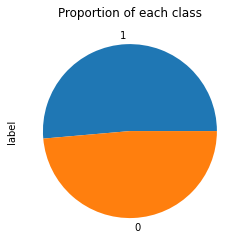

In [ ]:
# Print actual value count
print(f"Value counts for each class:\n\n{df_labeled.label.value_counts()}\n")

# Display pie chart to visually check the proportion
df_labeled.label.value_counts().plot.pie(y='label', title='Proportion of each class')
plt.show()

*There is roughly the same number of data points for each class so class imbalance is not an issue for this particular dataset.*

**Cleaning the dataset**

If you scroll back to the cell where you inspected the data, you will realize that the dataframe includes information that is not relevant for the task at hand. At the moment, you are only interested in the comments and the corresponding labels (the video that each comment belongs to will be used later). Let's drop the remaining columns.

In [ ]:
# Drop unused columns
df_labeled = df_labeled.drop(['index', 'COMMENT_ID', 'AUTHOR', 'DATE'], axis=1)

# Look at the cleaned dataset
df_labeled.head()

,text,label
0,great song you go katy!﻿,0
1,adf.ly /KlD3Y,1
2,hey guys im 17 years old remixer and producer ...,1
3,Check out this video on YouTube: <br />﻿,1
4,hey you ! check out the channel of Alvar Lake !!,1


In [ ]:
from sklearn.model_selection import train_test_split

# Save the text into the X variable
X = df_labeled.drop("label", axis=1)

# Save the true labels into the y variable
y = df_labeled["label"]

# Use 1/5 of the data for testing later
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Print number of comments for each set
print(f"There are {X_train.shape[0]} comments for training.")
print(f"There are {X_test.shape[0]} comments for testing")

There are 1564 comments for training.
There are 392 comments for testing


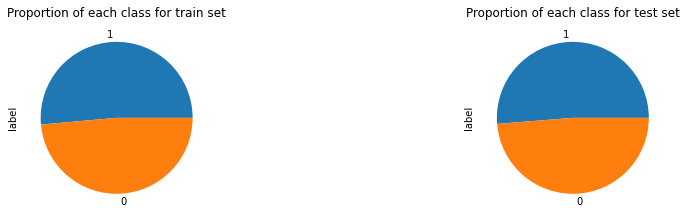

In [ ]:
plt.subplot(1, 3, 1)
y_train.value_counts().plot.pie(y='label', title='Proportion of each class for train set', figsize=(10, 6))

plt.subplot(1, 3, 3)
y_test.value_counts().plot.pie(y='label', title='Proportion of each class for test set', figsize=(10, 6))

plt.tight_layout()
plt.show()

*Both, the training and test sets a balanced proportion of examples per class. So, the code successfully implemented stratification.*


**Data Labeling**

Establishing performance lower and upper bounds for reference
To properly compare different labeling strategies you need to establish a baseline for model accuracy, in this case you will establish both a lower and an upper bound to compare against.

Calculate accuracy of a labeling strategy
CountVectorizer is a handy tool included in the sklearn ecosystem to encode text based data.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Allow unigrams and bigrams
vectorizer = CountVectorizer(ngram_range=(1, 5))

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB


def calculate_accuracy(X_tr, y_tr, X_te=X_test, y_te=y_test, 
                       clf=MultinomialNB(), vectorizer=vectorizer):
    
    # Encode train text
    X_train_vect = vectorizer.fit_transform(X_tr.text.tolist())
    
    # Fit model
    clf.fit(X=X_train_vect, y=y_tr)
    
    # Vectorize test text
    X_test_vect = vectorizer.transform(X_te.text.tolist())
    
    # Make predictions for the test set
    preds = clf.predict(X_test_vect)
    
    # Return accuracy score
    return accuracy_score(preds, y_te)

In [ ]:
# Empty dictionary
accs = dict()

**Random Labeling**

Generating random labels is a natural way to establish a lower bound. You will expect that any successful alternative labeling model to outperform randomly generated labels.

Now let's calculate the accuracy for the random labeling method

In [ ]:
# Calculate random labels
rnd_labels = np.random.randint(0, 2, X_train.shape[0])

# Feed them alongside X_train to calculate_accuracy function
rnd_acc = calculate_accuracy(X_train, rnd_labels)

rnd_acc

0.5408163265306123

In [ ]:
# Empty list to save accuracies
rnd_accs = []

for _ in range(10):
    # Add every accuracy to the list
    rnd_accs.append(calculate_accuracy(X_train, np.random.randint(0, 2, X_train.shape[0])))

# Save result in accs dictionary
accs['random-labels'] = sum(rnd_accs)/len(rnd_accs)

# Print result
print(f"The random labelling method achieved and accuracy of {accs['random-labels']*100:.2f}%")

The random labelling method achieved and accuracy of 47.40%


Random labelling is completely disregarding the information from the solution space you are working on, and is just guessing the correct label. You can't probably do worse than this (or maybe you can). For this reason, this method serves as reference for comparing other labeling methods

**Labeling with true values**

Now let's look at the other end of the spectrum, this is using the correct labels for your data points. Let's retrain the Multinomial Naive Bayes classifier with the actual labels

In [ ]:
# Calculate accuracy when using the true labels
true_acc = calculate_accuracy(X_train, y_train)

# Save the result
accs['true-labels'] = true_acc

print(f"The true labelling method achieved and accuracy of {accs['true-labels']*100:.2f}%")

The true labelling method achieved and accuracy of 92.86%


Training with the true labels produced a noticeable boost in accuracy. This is expected as the classifier is now able to properly identify patterns in the training data which were lacking with randomly generated labels.

Achieving higher accuracy is possible by either fine-tunning the model or even selecting a different one. For the time being you will keep the model as it is and use this accuracy as what we should strive for with the automatic labeling algorithms you will see next.

**Automatic labeling** - Trying out different labeling strategies
Let's suppose that for some reason you don't have access to the true labels associated with each data point in this dataset. It is a natural idea to think that there are patterns in the data that will provide clues of which are the correct labels. This is of course very dependant on the kind of data you are working with and to even hypothesize which patterns exist requires great domain knowledge.

The dataset used in this lab was used for this reason. It is reasonable for many people to come up with rules that might help identify a spam comment from a non-spam one for a Youtube video. In the following section you will be performing automatic labeling using such rules. You can think of each iteration of this process as a labeler with different criteria for labeling and your job is to hire the most promising one.

Notice the word rules. In order to perform automatic labeling you will define some rules such as "if the comment contains the word 'free' classify it as spam".

First things first. Let's define how we are going to encode the labeling:

SPAM is represented by 1
NOT_SPAM by 0
NO_LABEL as -1
You might be wondering about the NO_LABEL keyword. Depending on the rules you come up with, these might not be applicable to some data points. For such cases it is better to refuse from giving a label rather than guessing, which you already saw yields poor results.

First iteration - Define some rules
For this first iteration you will create three rules based on the intuition of common patterns that appear on spam comments. The rules are simple, classify as SPAM if any of the following patterns is present within the comment or NO_LABEL otherwise:

free - spam comments usually lure users by promoting free stuff
subs - spam comments tend to ask users to subscribe to some website or channel
http - spam comments include links very frequently

In [ ]:
def labeling_rules_1(x):
    
    # Convert text to lowercase
    x = x.lower()
    
    # Define list of rules
    rules = [
        "free" in x,
        "subs" in x,
        "http" in x
    ]
    
    # If the comment falls under any of the rules classify as SPAM
    if any(rules):
        return 1
    
    # Otherwise, NO_LABEL
    return -1

In [ ]:
# Apply the rules the comments in the train set
labels = [labeling_rules_1(label) for label in X_train.text]

# Convert to a numpy array
labels = np.asarray(labels)

# Take a look at the automatic labels
labels

array([-1, -1, -1, ...,  1, -1, -1])

In [ ]:
# Create the automatic labeled version of X_train by removing points with NO_LABEL label
X_train_al = X_train[labels != -1]

# Remove predictions with NO_LABEL label
labels_al = labels[labels != -1]

print(f"Predictions with concrete label have shape: {labels_al.shape}")

print(f"Proportion of data points kept: {labels_al.shape[0]/labels.shape[0]*100:.2f}%")

Predictions with concrete label have shape: (375,)
Proportion of data points kept: 23.98%


Notice that only 379 data points remained out of the original 1564. The rules defined didn't provide enough context for the labeling algorithm to settle on a label, so around 75% of the data has been trimmed.

Let's test the accuracy of the model when using these automatic generated labels:

In [ ]:
# Compute accuracy when using these labels
iter_1_acc = calculate_accuracy(X_train_al, labels_al)

# Display accuracy
print(f"First iteration of automatic labeling has an accuracy of {iter_1_acc*100:.2f}%")

# Save the result
accs['first-iteration'] = iter_1_acc

First iteration of automatic labeling has an accuracy of 51.28%


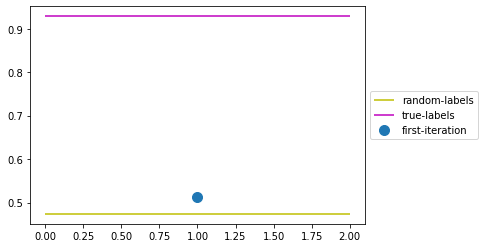

In [ ]:
def plot_accuracies(accs=accs):
    colors = list("rgbcmy")
    items_num = len(accs)
    cont = 1

    for x, y in accs.items():
        if x in ['true-labels', 'random-labels', 'true-labels-best-clf']:
            plt.hlines(y, 0, (items_num-2)*2, colors=colors.pop())
        else:
            plt.scatter(cont, y, s=100)
            cont+=2
    plt.legend(accs.keys(), loc="center left",bbox_to_anchor=(1, 0.5))
    plt.show()
    
plot_accuracies()

This first iteration had an accuracy very close to the random labeling, we should strive to do better than this.

Before moving forward let's define the label_given_rules function that performs all of the steps you just saw, these are:



*   Apply the rules to a dataframe of comments
*   Cast the resulting labels to a numpy array
*   Delete all data points with NO_LABEL as label
*   Calculate the accuracy of the model using the automatic labels
*   Save the accuracy for plotting
*   Print some useful metrics of the process




In [ ]:
def label_given_rules(df, rules_function, name, 
                      accs_dict=accs, verbose=True):
    
    # Apply labeling rules to the comments
    labels = [rules_function(label) for label in df.text]
    
    # Convert to a numpy array
    labels = np.asarray(labels)
    
    # Save initial number of data points
    initial_size = labels.shape[0]
    
    # Trim points with NO_LABEL label
    X_train_al = df[labels != -1]
    labels = labels[labels != -1]
    
    # Save number of data points after trimming
    final_size = labels.shape[0]
    
    # Compute accuracy
    acc = calculate_accuracy(X_train_al, labels)
    
    # Print useful information
    if verbose:
        print(f"Proportion of data points kept: {final_size/initial_size*100:.2f}%\n")
        print(f"{name} labeling has an accuracy of {acc*100:.2f}%\n")
        
    # Save accuracy to accuracies dictionary
    accs_dict[name] = acc
    
    return X_train_al, labels, acc

Going forward we should come up with rules that have a better coverage of the training data, thus making pattern discovery an easier task. Also notice how the rules were only able to label as either SPAM or NO_LABEL, we should also create some rules that help the identification of NOT_SPAM comments.

**Second iteration - Coming up with better rules**
If you inspect the comments in the dataset you might be able to distinguish certain patterns at a glimpse. For example, not spam comments often make references to either the number of views since these were the most watched videos of 2015 or the song in the video and its contents . As for spam comments other common patterns are to promote gifts or ask to follow some channel or website.

Let's create some new rules that include these patterns:

In [ ]:
def labeling_rules_2(x):
    
    # Convert text to lowercase
    x = x.lower()
    
    # Define list of rules to classify as NOT_SPAM
    not_spam_rules = [
        "view" in x,
        "song" in x
    ]
    
    # Define list of rules to classify as SPAM
    spam_rules = [
        "free" in x,
        "subs" in x,
        "gift" in x,
        "follow" in x,
        "http" in x
    ]
    
    # Classify depending on the rules
    if any(not_spam_rules):
        return 0
    
    if any(spam_rules):
        return 1
    
    return -1

Proportion of data points kept: 44.05%

second-iteration labeling has an accuracy of 72.19%



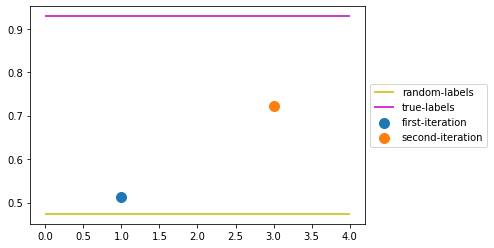

In [ ]:
label_given_rules(X_train, labeling_rules_2, "second-iteration")

plot_accuracies()

In [ ]:
from statistics import mean

print(f"NOT_SPAM comments have an average of {mean([len(t) for t in df_labeled[df_labeled.label==0].text]):.2f} characters.")
print(f"SPAM comments have an average of {mean([len(t) for t in df_labeled[df_labeled.label==1].text]):.2f} characters.")

NOT_SPAM comments have an average of 49.64 characters.
SPAM comments have an average of 137.34 characters.


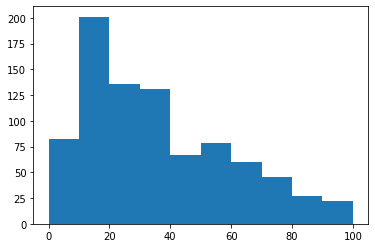

In [ ]:
plt.hist([len(t) for t in df_labeled[df_labeled.label==0].text], range=(0,100))
plt.show()

In [ ]:
def labeling_rules_3(x):
    
    # Convert text to lowercase
    x = x.lower()
    
    # Define list of rules to classify as NOT_SPAM
    not_spam_rules = [
        "view" in x,
        "song" in x,
        len(x) < 30
    ]
    

    # Define list of rules to classify as SPAM
    spam_rules = [
        "free" in x,
        "subs" in x,
        "gift" in x,
        "follow" in x,
        "http" in x,
        "check out" in x
    ]
    
    # Classify depending on the rules
    if any(not_spam_rules):
        return 0
    if any(spam_rules):
        return 1
    
    return -1

Proportion of data points kept: 77.49%

third-iteration labeling has an accuracy of 90.05%



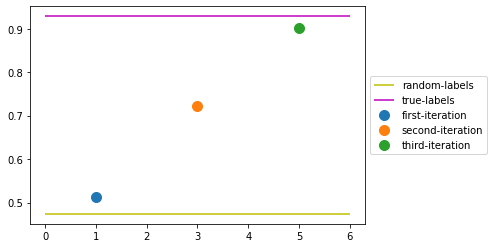

In [ ]:
label_given_rules(X_train, labeling_rules_3, "third-iteration")

plot_accuracies()

**Third Iteration - Even more rules**
These new rules do a pretty good job at both, covering the dataset and having a good model accuracy. To be more concrete this labeling strategy reached an accuracy of ~86%! We are getting closer and closer to the upper bound defined by using the true labels.

We could keep going on adding more rules to improve accuracy and we do encourage you to try it out yourself!

Come up with your own rules
The following cells contain some code to help you inspect the dataset for patterns and to test out these patterns. The ones used before are commented out in case you want start from scratch or re-use them.

In [ ]:
# Configure pandas to print out all rows to check the complete dataset
pd.set_option('display.max_rows', None)

# Check NOT_SPAM comments
df_labeled[df_labeled.label==0]

,text,label
0,great song you go katy!﻿,0
7,"Its a good song and i like her video clip, bec...",0
8,This song is so beauty,0
9,Love Song﻿,0
11,Love this song! My soccer team made a cd for o...,0
13,like me﻿,0
14,best song ever (y)﻿,0
16,the most viewed youtube video of all time?﻿,0
20,sorry to all my haters<br /><br /><br /><br />...,0
21,If only I had the body like Katy Perry :)). Sh...,0


In [ ]:
# Check SPAM comments
df_labeled[df_labeled.label==1]

,text,label
1,adf.ly /KlD3Y,1
2,hey guys im 17 years old remixer and producer ...,1
3,Check out this video on YouTube: <br />﻿,1
4,hey you ! check out the channel of Alvar Lake !!,1
5,Hey guys I&#39;m 87 cypher im 11 years old and...,1
6,The new Makeup Transformation with Integrated ...,1
10,check out my channel for rap and hip hop music,1
12,Help Please!! http://www.gofundme.com/RJanima...,1
15,"Hey, check out my new website!! This site is a...",1
17,Hello everyone :) I know most of you probably ...,1


Proportion of data points kept: 1.98%

your-iteration labeling has an accuracy of 51.28%



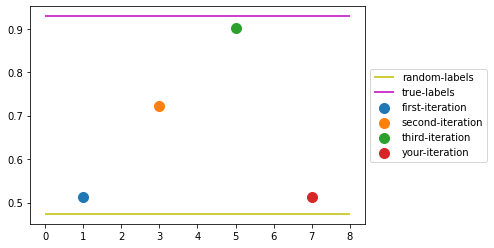

In [ ]:
def your_labeling_rules(x):
    
    # Convert text to lowercase
    x = x.lower()
    
    # Define your rules for classifying as NOT_SPAM
    not_spam_rules = [
#         "view" in x,
#         "song" in x,
#         len(x) < 30
    ]
    

    # Define your rules for classifying as SPAM
    spam_rules = [
          "free" in x,
#         "subs" in x,
#         "gift" in x,
#         "follow" in x,
#         "http" in x,
#         "check out" in x
    ]
    
    # Classify depending on your rules
    if any(not_spam_rules):
        return 0
    
    if any(spam_rules):
        return 1
    
    return -1


try:
    label_given_rules(X_train, your_labeling_rules, "your-iteration")
    plot_accuracies()
    
except ValueError:
    print("You have not defined any rules.")